## Convolutional Neural Networks (CNN) for CIFAR-10 Dataset

##### Author : HSO
##### Email: hugo.soares@fe.up.pt

## Import Modules

In [1]:
# Use GPU for Theano, comment the line for use CPU instead
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu, floatX=float32"

In [2]:
# if using tensorflow, se image dimensions order
from keras import backend as K
if K.backend() == 'tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(1234)
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

## Load CIFAR10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images.

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols = train_features.shape
num_test, _, _, _ = test_features.shape
num_classes = len(np.unique(train_labels)) # Attain the number of unique classes

## Show Examples from Each Class

<function matplotlib.pyplot.show>

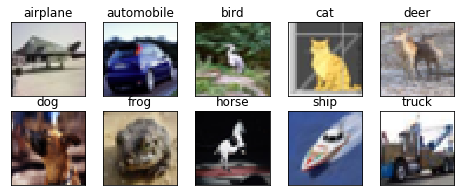

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0] # Look for labels equal to the i
    features_idx = train_features[idx,::] # Look for the features regarding class idx
    img_num = np.random.randint(features_idx.shape[0]) # Set the image number to show
    im = np.transpose(features_idx[img_num,::], (1,2,0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show

## Data Pre-processing

In [6]:
train_features = train_features.astype('float32')/255 # Normalize features values
test_features = test_features.astype('float32')/255 # Normalize features values
# Convert the class labels into binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Function to plot model accuracy and loss

In [7]:
def plotModelHistory(model_history):
    fig, axs = plt.subplots(1,2, figsize(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1), model_history.history['acc']) # X: Number of values, Y: Values
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1), model_history.history['val_acc']) # X: Number of values, Y: Values
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].xticks(range(1,len(model_history.history['acc'])+1), len(model_history.history['acc'])/10) # List of positions ticks should be placed
    axs[0].legend(['train', 'val'], loc = 'best')
    
    # Summarize history for loss
    axs[0].plot(range(1,len(model_history.history['loss'])+1), model_history.history['loss']) # X: Number of values, Y: Values
    axs[0].plot(range(1,len(model_history.history['val_loss'])+1), model_history.history['val_loss']) # X: Number of values, Y: Values
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].xticks(range(1,len(model_history.history['loss'])+1), len(model_history.history['loss'])/10) # List of positions ticks should be placed
    axs[0].legend(['train', 'val'], loc = 'best')
    plt.show()
    

In [10]:
## Function to compute test accuracy
def computeAccurary(test_x, test_y, model):
    preds = model.predict(test_x)
    preds_class = np.argmax(preds, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(preds_class == true_class)
    accuracy = float(num_correct)/preds.shape[0]
    return (accuracy*100)

## Convolutional Neural Network Arquitecture for CIFAR-10 Dataset

###### Quick Notes:
* Epoch: Complete round for the whole dataset

* Batch Size: Number of samples used to train the network

* Max Polling: Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned. This is done to in part to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation. Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation. We utilise the fact that consecutive layers of the network are activated by “higher” or more complex features that are exhibited by a larger area of the networks input data. A pooling layer effectively down samples the output of the prior layer, reducing the number of operations required for all the following layers, but still passing on the valid information from the previous layer.

* Dropout: Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. The term "dropout" refers to dropping out units (both hidden and visible) in a neural network.

* Dense/fully connected layer: A linear operation on the layer’s input vector.
Step - 1 : Convolution
Step - 2 : Pooling
Step - 3 : Flattening
Step - 4 : Full connection

* Flatten: Flattening is the process of converting all the resultant 2 dimensional arrays into a single long continuous linear vector.

* Softmax: In mathematics, the softmax function, or normalized exponential function,[1]:198 is a generalization of the logistic function that "squashes" a K-dimensional vector z {\displaystyle \mathbf {z} } \mathbf {z} of arbitrary real values to a K-dimensional vector σ ( z ) {\displaystyle \sigma (\mathbf {z} )} \sigma (\mathbf {z} ) of real values in the range (0, 1) that add up to 1.  softmax function in CNN, where the final output is a multinomial logistic).

* Categorical Cross Entropy: To the beyond intuition part I would also add that cross entropy also emerges from maximum likelihood estimation for logistic regression model

* Adam optimizer: Adam is an optimization algorithm that can used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. I will quote liberally from their paper in this post, unless stated otherwise. Link: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/



In [17]:
# Definig the model architecture
model = Sequential() # Sequantial

model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(3, 32, 32))) # First Convolution Layer (image size)
model.add(Activation('relu')) # Activation function (rectified linear unit x<0 -> 0, x>0 -> x)
model.add(Convolution2D(48, 3, 3)) # Second Convolution Layer
model.add(Activation('relu')) # Activation function (rectified linear unit x<0 -> 0, x>0 -> x)
model.add(MaxPooling2D(pool_size=(2,2))) # Max polling 
model.add(Dropout(0.25)) # Dropout 25% of the unit to avoid overfittin

model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Max polling 
model.add(Dropout(0.25)) # Dropout

model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Max polling 
model.add(Dropout(0.25)) # Dropout

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5)) # Dropout

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5)) # Dropout
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
time_start = time.time()
model_info = model.fit(train_features, train_labels,
                      batch_size=128, epochs=200,
                      validation_data = (test_features, test_labels),
                      verbose=1)
time_end = time.time()

# Plot model history
plotModelHistory(model_info)
print("Model tool %0.2f seconds to train" %(time_end- time_start))

# Compute accuracy
print(" Accuracy on test data is: %0.2f"% computeAccurary(test_features, test_labels, model))


/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", input_shape=(3, 32, 32...)`
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3))`


Train on 50000 samples, validate on 10000 samples
Epoch 1/200
 1408/50000 [..............................] - ETA: 11154s - loss: 2.3419 - acc: 0.1058

KeyboardInterrupt: 

## Train Model With  Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range = 0.2,
                            horizontal_flip=True)

# Train the model
time_start = time.time()
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], epochs = 200, 
                                 validation_data = (test_features, test_labels), verbose=0)
time_end = time.time()

# Plot model history
plotModelHistory(model_info)
print("Model tool %0.2f seconds to train" %(time_end- time_start))

# Compute accuracy
print(" Accuracy on test data is: %0.2f"% computeAccurary(test_features, test_labels, model))
